In [38]:
import pandas as pd
import numpy as np

data_location = "../data/data_prepared.pkl"


In [39]:
output_shape = 77
raw_data = pd.read_pickle(data_location).astype(float)
raw_data = raw_data.iloc[:,:output_shape]

In [40]:
from sklearn. preprocessing import StandardScaler
def generate_time_features(X):
        # hour, month, day, dayOfWeek, ISvacation,  ISweekend
        X = X.copy()
        X["Hour"] = X.index.hour
        X["Month"] = X.index.month
        X["Day"] = X.index.day
        X["weekday"] = X.index.weekday
        X["IsWeekend"] = np.array(map(lambda i:0 if i <5 else 1,X.index.weekday))
        return X
features = generate_time_features(raw_data).astype(float)
features  = features/np.mean(features,axis= 0)
targets = raw_data.astype(float)

In [41]:
import keras
sampling_rate = 1
sequence_length = 168
forecast_steps = 1
delay = sampling_rate * (sequence_length + forecast_steps - 1)
batch_size = 128



In [42]:
num_row = raw_data.shape[0] - delay
num_train_samples = int(0.8 * num_row)
num_val_samples = int(0.1 * num_row)
num_test_samples = num_row- num_train_samples - num_val_samples

In [43]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [44]:
for inputs, targets in train_dataset:
    print(inputs.shape, targets.shape)

(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(6, 168, 82) (6, 77)


In [45]:
def get_predict_and_true(model,test_dataset):
    n = 0
    for inputs,targets in test_dataset:
        input_sample = inputs
        target_sample = targets
        n+=1
        if n>=1:
            break
    y_pred = model.predict(input_sample)
    y_true = target_sample
    return y_true, y_pred
import matplotlib.pyplot as plt
def calculate_smape(y_true, y_pred):
   
    #Ensure no division by zero
    epsilon = np.finfo(np.float64).eps
    
    # Calculate the absolute differences
    absolute_differences = np.abs(y_pred - y_true)
    
    # Calculate the denominators
    denominators = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1
    
    # Calculate individual sMAPE values
    smape_values = (absolute_differences / denominators) 
    smape = np.mean(smape_values,axis=0) * 100

    return smape
def cal_metrics(y_true,y_pred):
    smape = calculate_smape(y_true,y_pred)
    mse = np.mean((y_pred - y_true)**2,axis = 0)
    mae = np.mean(np.abs(y_pred - y_true),axis=0)
    return [mse,mae,smape]

def plot_result(y_true,y_pred,area_index):
    x = range(len(y_true))
    num_area = len(area_index)
    plot_index = 1
    plt.figure(figsize=(12,20))
    for i in area_index:
        area_predict = y_pred[:,i]
        area_true = y_true[:,i]
        area_name = raw_data.columns[i]

        metrics = cal_metrics(y_true,y_pred)
        area_diff = area_predict - area_true
        plt.subplot(num_area,1,plot_index)
        plt.title(f"{area_name} mse: {metrics[0][i]:.2f} mae: {metrics[1][i]:.2f} smape: {metrics[2][i]:.2f}")
        plt.plot(x,area_predict,label = "predict")
        plt.plot(x,area_true,label = "real")
        plt.plot(x,area_diff,label = "difference")
        plt.legend()

        plot_index +=1



In [46]:
# Dense model
from tensorflow import keras 
from keras import layers
  
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",          
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
         
         
       

Epoch 1/100
17/17 [==============================] - 1s 71ms/step - loss: 160.5963 - mae: 5.9411 - val_loss: 10.8581 - val_mae: 1.3580
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 57.8779 - mae: 3.7622 - val_loss: 5.3558 - val_mae: 1.1595
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 56.4421 - mae: 3.6333 - val_loss: 4.9019 - val_mae: 1.2329
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 39.9641 - mae: 3.0876 - val_loss: 5.4431 - val_mae: 1.2585
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 39.6753 - mae: 2.9821 - val_loss: 5.8067 - val_mae: 1.3192
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 30.8073 - mae: 2.7905 - val_loss: 7.0705 - val_mae: 1.3809
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 29.8864 - mae: 2.6591 - val_loss: 7.5786 - val_mae: 1.4284
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss

4/4 [==============================] - 0s 14ms/step


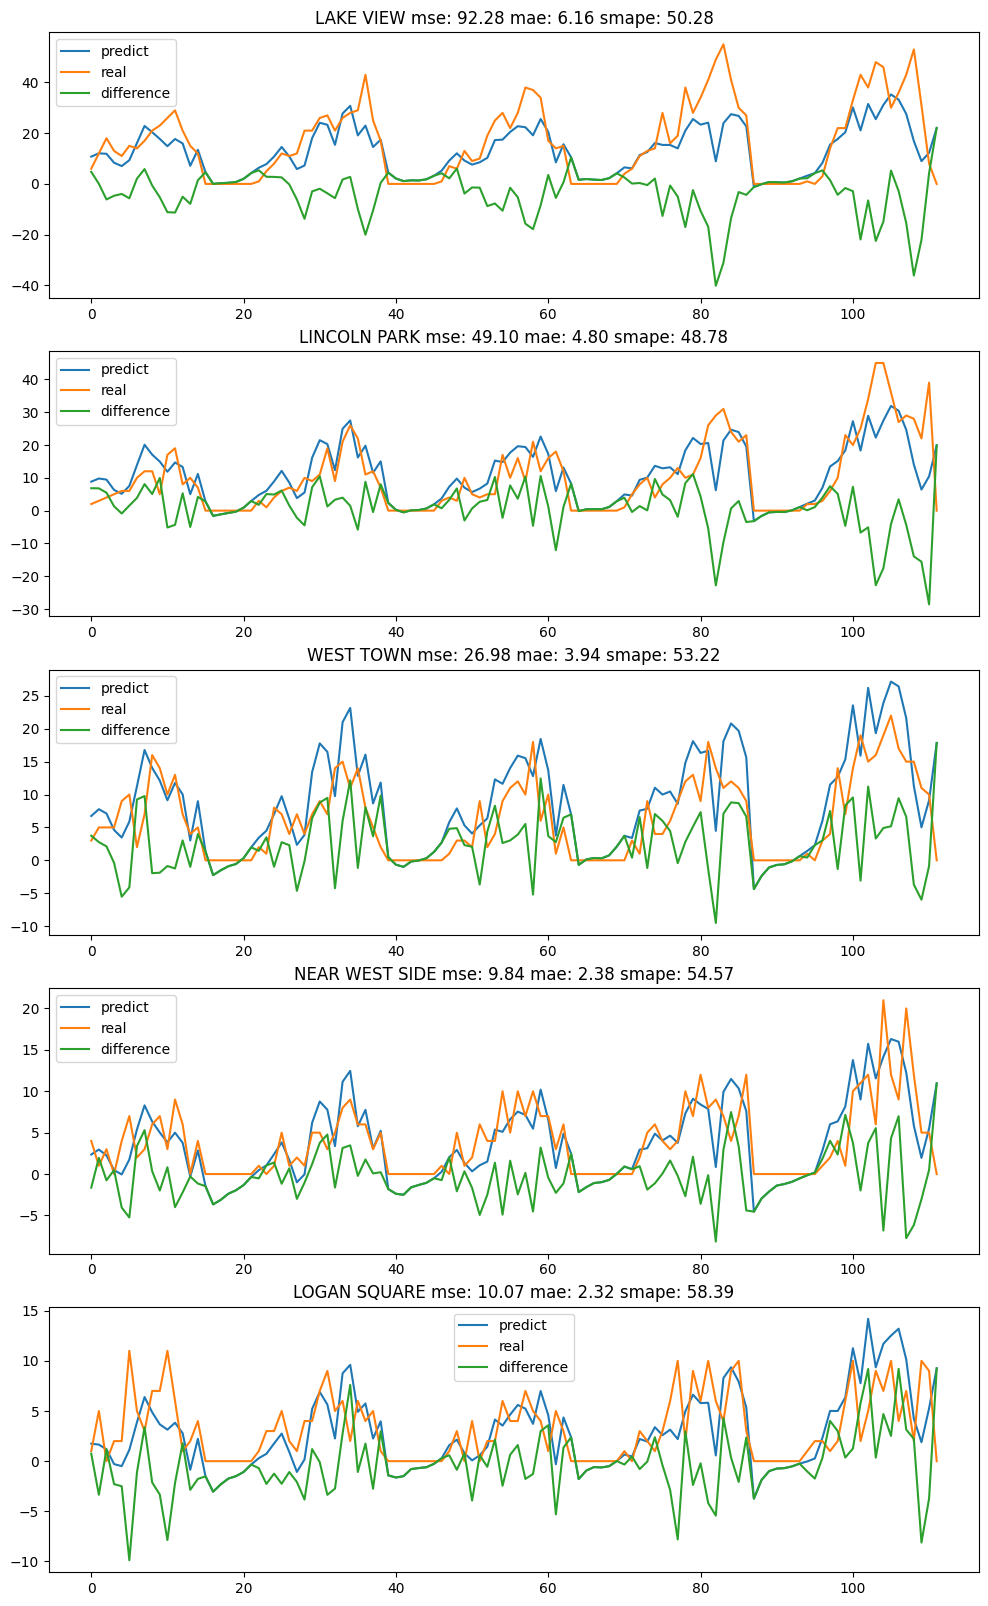

In [77]:
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,range(5))  

In [48]:
# CONV 1D
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 1s 74ms/step - loss: 114.8689 - mae: 4.2724 - val_loss: 13.5513 - val_mae: 1.7366
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 78.0190 - mae: 3.9078 - val_loss: 11.4955 - val_mae: 1.4929
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 60.3407 - mae: 3.4204 - val_loss: 10.1936 - val_mae: 1.4081
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 50.6430 - mae: 3.2393 - val_loss: 9.3579 - val_mae: 1.3740
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 45.8116 - mae: 3.0927 - val_loss: 8.7421 - val_mae: 1.3451
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 42.7639 - mae: 2.9551 - val_loss: 8.2730 - val_mae: 1.3284
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 40.7803 - mae: 2.8876 - val_loss: 7.8151 - val_mae: 1.3165
Epoch 8/100
17/17 [==============================] - 0s 10ms/step

4/4 [==============================] - 0s 2ms/step


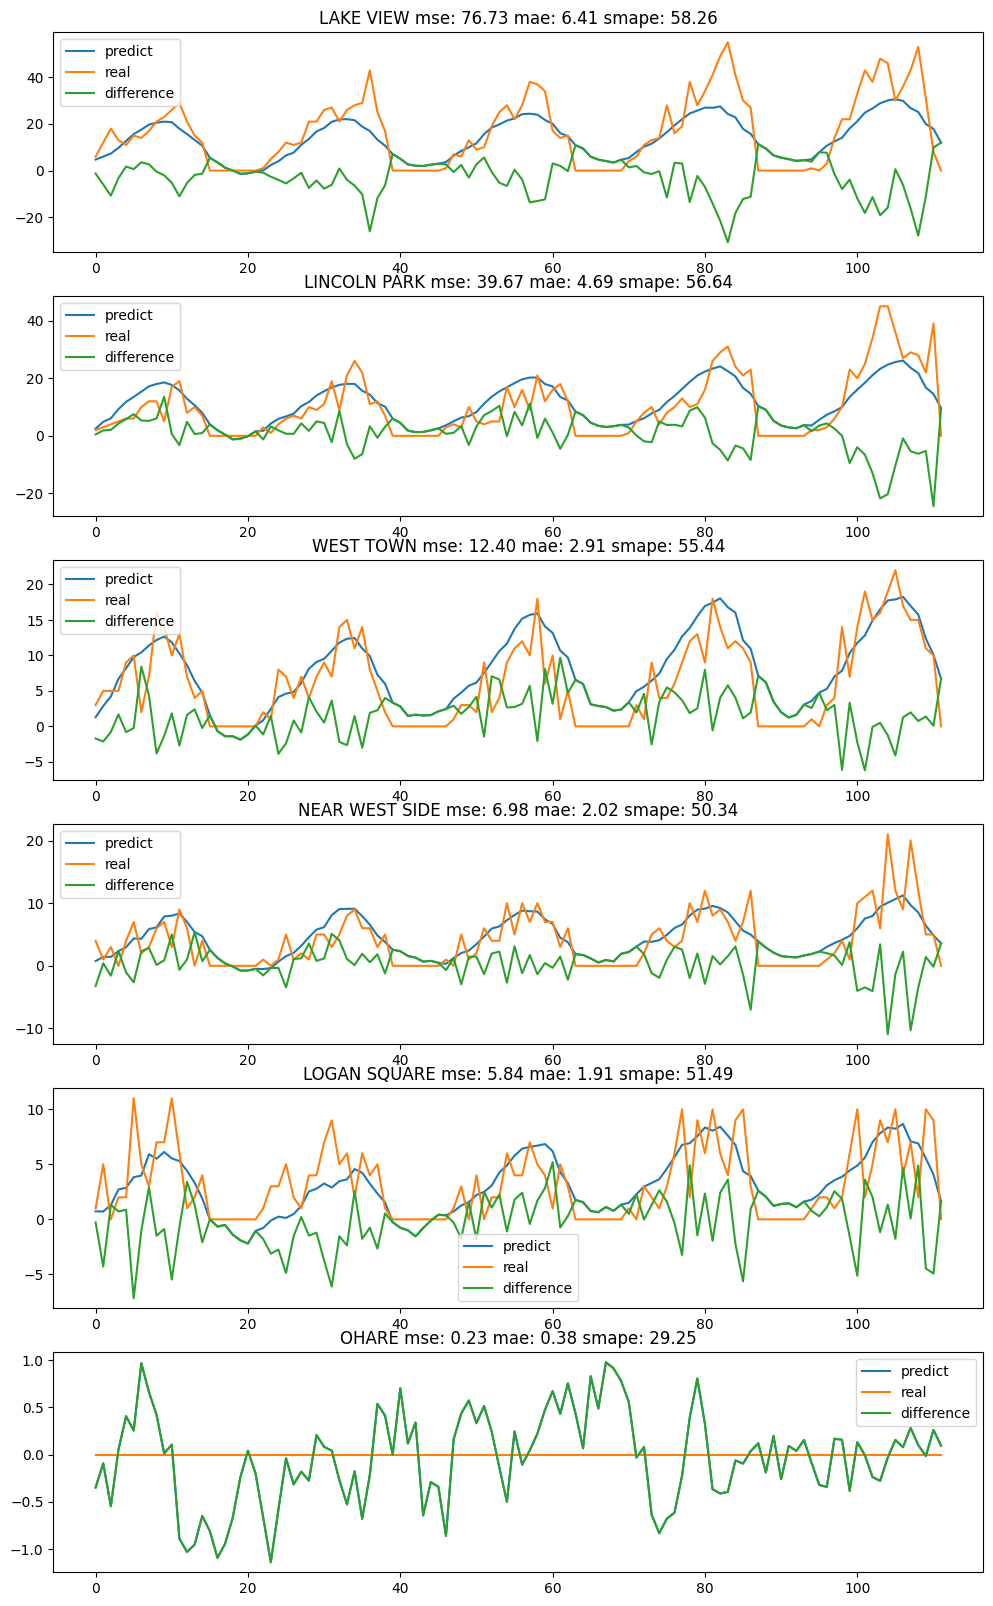

In [54]:
model = keras.models.load_model("jena_conv.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,np.append(np.arange(5),-1))  

In [50]:
# LSTM
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.LSTM(32)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 58ms/step - loss: 137.4464 - mae: 3.4503 - val_loss: 19.2302 - val_mae: 1.3928
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 131.7368 - mae: 3.3670 - val_loss: 17.7766 - val_mae: 1.4374
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 128.0693 - mae: 3.3322 - val_loss: 16.9771 - val_mae: 1.4799
Epoch 4/100
17/17 [==============================] - 0s 13ms/step - loss: 125.5054 - mae: 3.3021 - val_loss: 16.3295 - val_mae: 1.4930
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 123.1306 - mae: 3.2556 - val_loss: 15.6450 - val_mae: 1.4729
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 120.6780 - mae: 3.1970 - val_loss: 15.0196 - val_mae: 1.4493
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 118.4311 - mae: 3.1393 - val_loss: 14.4623 - val_mae: 1.4240
Epoch 8/100
17/17 [==============================] - 0s

4/4 [==============================] - 0s 4ms/step


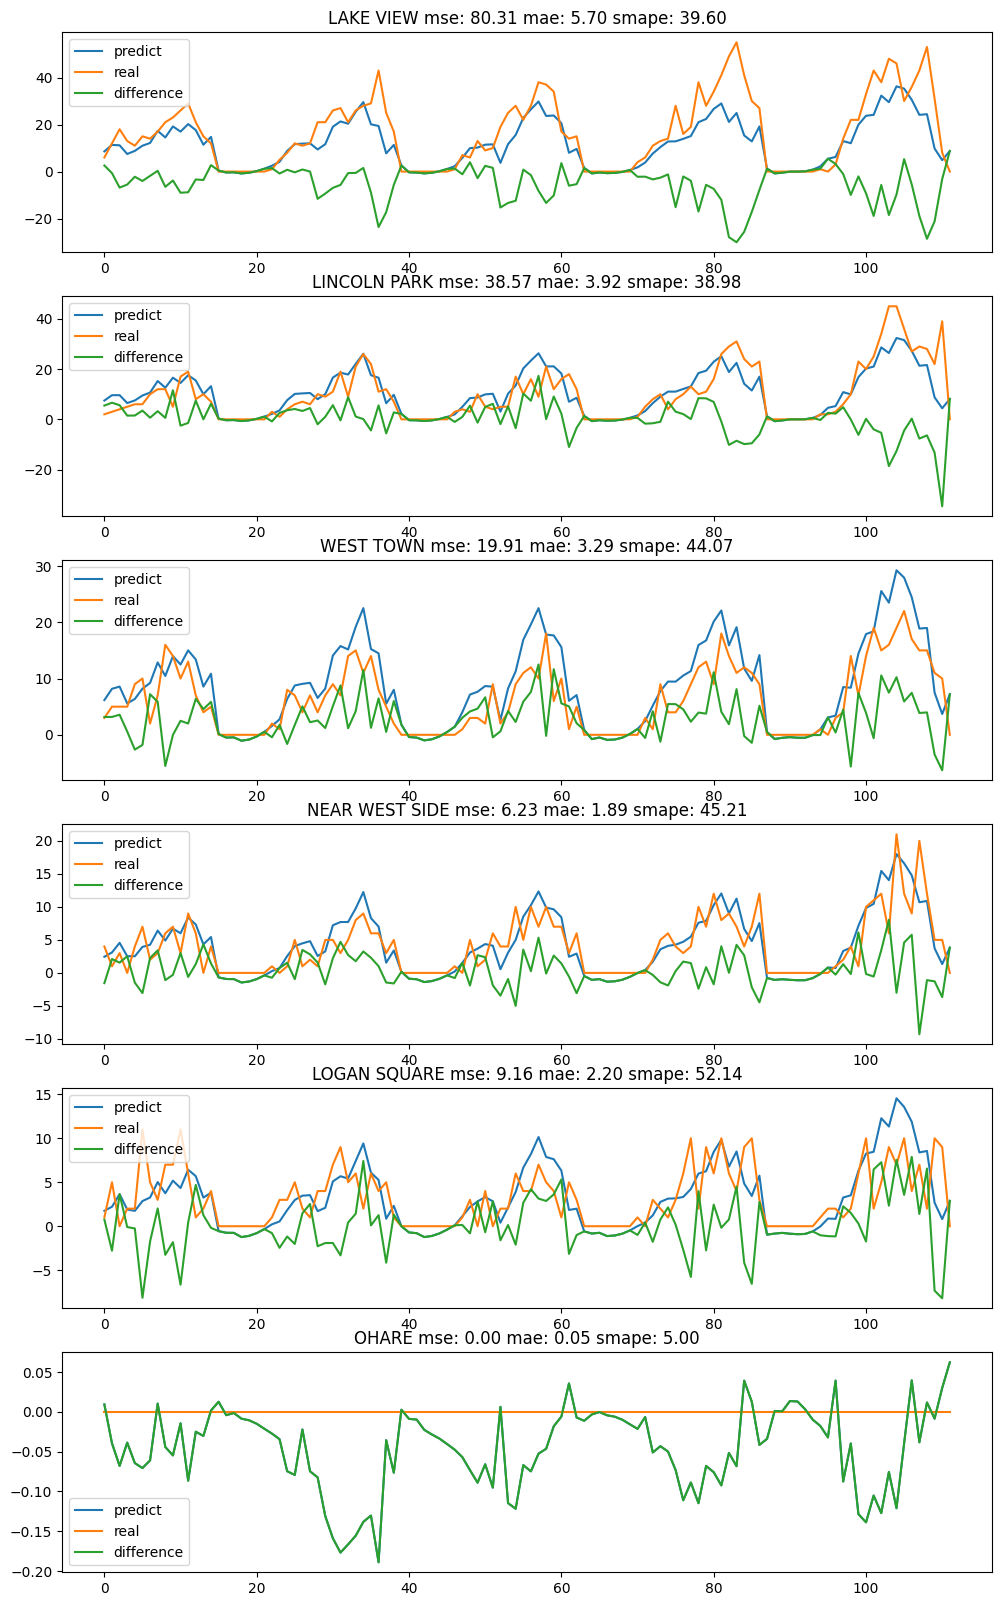

In [55]:
model = keras.models.load_model("_lstm.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,np.append(np.arange(5),-1)) 

In [52]:
# gru
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.GRU(32)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_gru.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 60ms/step - loss: 136.8559 - mae: 3.4390 - val_loss: 19.2578 - val_mae: 1.3889
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 132.0243 - mae: 3.3353 - val_loss: 17.9779 - val_mae: 1.4101
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 128.5221 - mae: 3.2849 - val_loss: 17.1072 - val_mae: 1.4351
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 125.7012 - mae: 3.2283 - val_loss: 16.3794 - val_mae: 1.4162
Epoch 5/100
17/17 [==============================] - 0s 12ms/step - loss: 123.1987 - mae: 3.1480 - val_loss: 15.7121 - val_mae: 1.3739
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 120.8860 - mae: 3.0684 - val_loss: 15.1271 - val_mae: 1.3366
Epoch 7/100
17/17 [==============================] - 0s 12ms/step - loss: 118.7297 - mae: 3.0033 - val_loss: 14.6159 - val_mae: 1.3142
Epoch 8/100
17/17 [==============================] - 0s

4/4 [==============================] - 0s 14ms/step


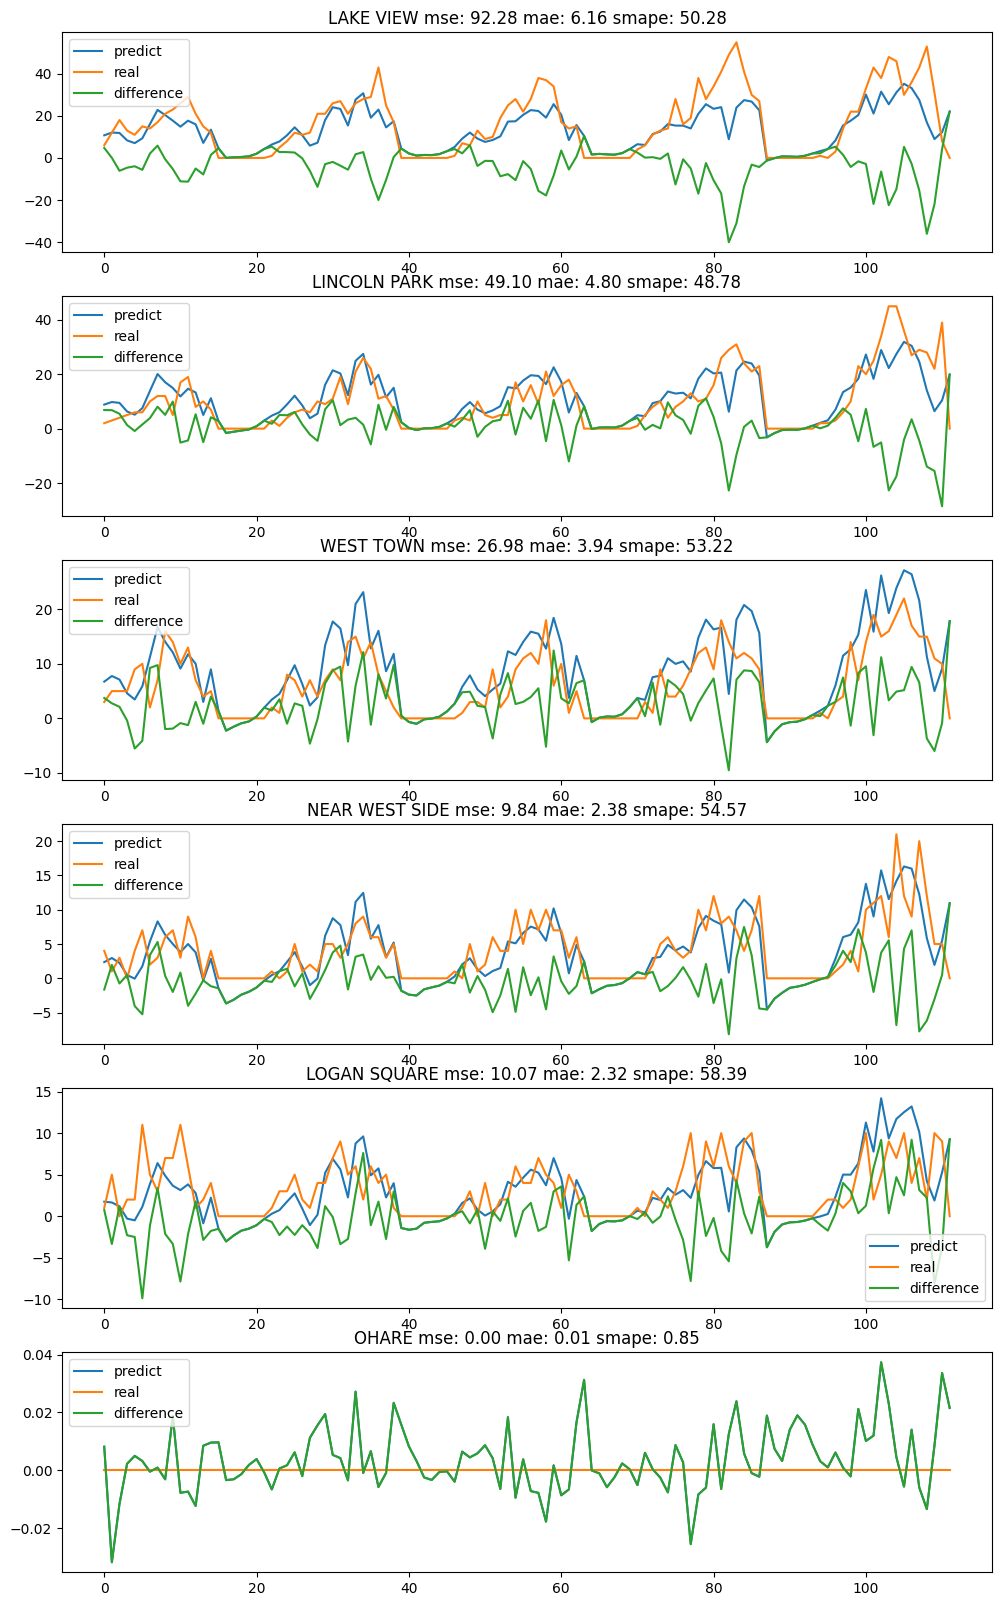

In [56]:
model = keras.models.load_model("_gru.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,np.append(np.arange(5),-1)) 

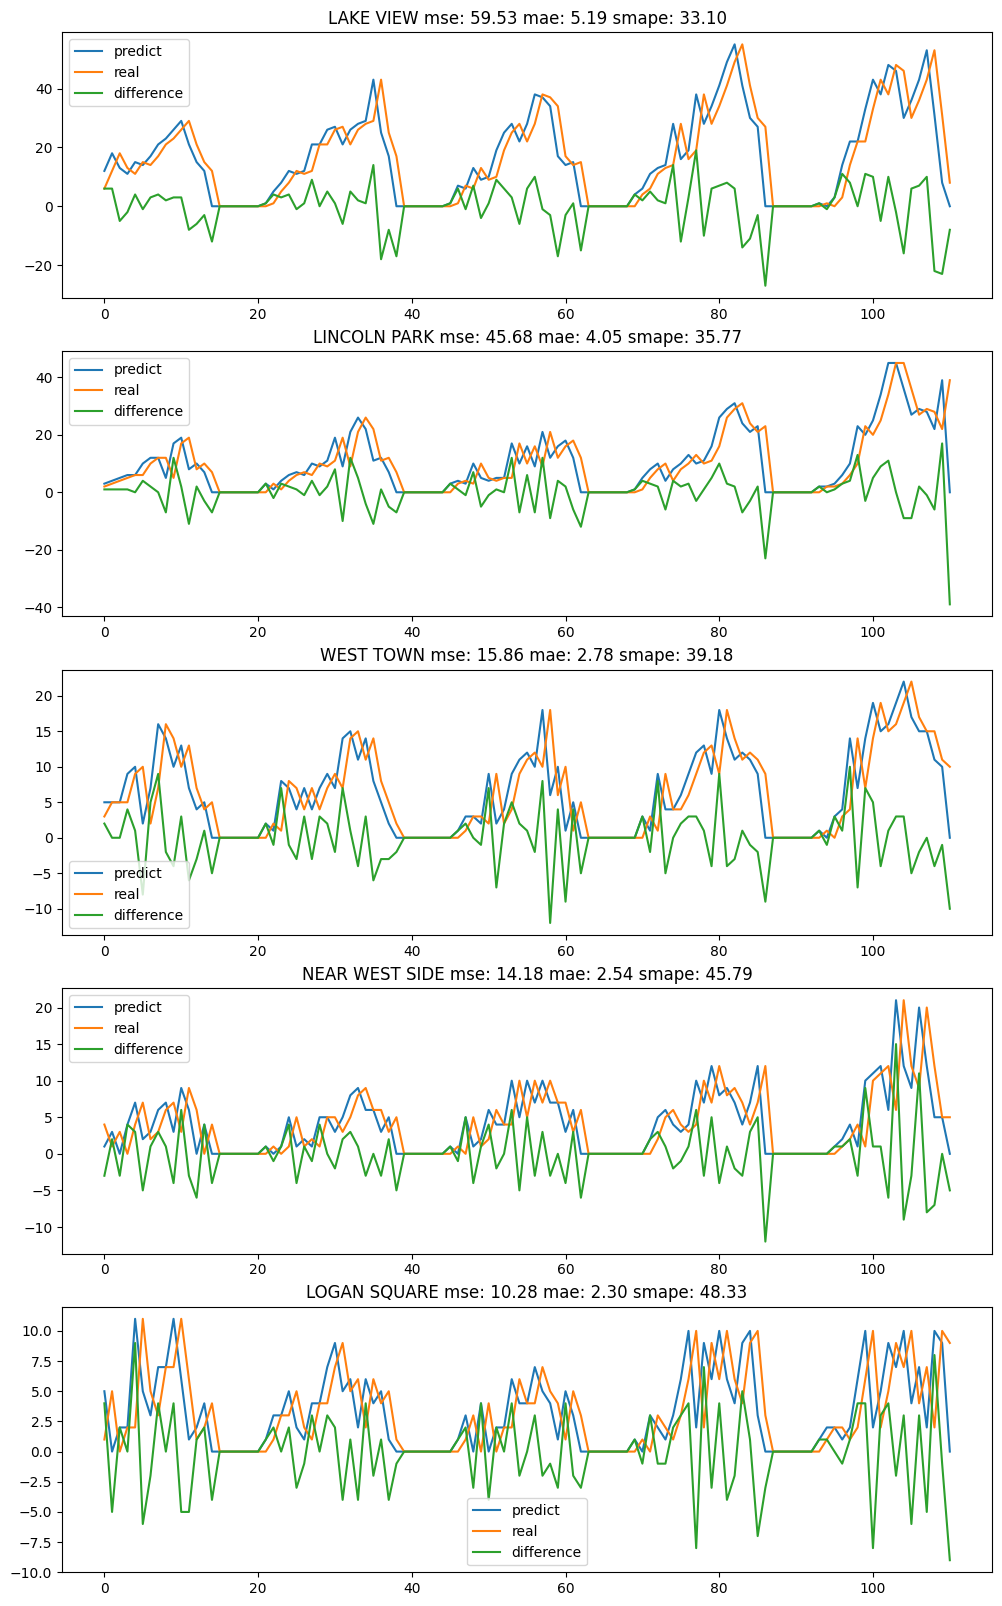

In [84]:
y_true_naive = y_true.numpy()
plot_result(y_true_naive[:-1,:],y_true_naive[1:,:],np.arange(5))
m = cal_metrics(y_true_naive[:-1,:],y_true_naive[1:,:])


In [88]:
for i in m:
    print(i.sum()/len(i))
    

3.18954018954019
0.700947700947701
22.887292976017957
